# Forecasting surface water extent in the Okavango delta

Using the results from our modelled discharge, upstream rainfall, and vector auto regression

### Load packages
Import Python packages that are used for the analysis.

In [1]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Analysis parameters

In [2]:
freq = 'Q-DEC'
data = 'results/okavango_all_datasets.csv'
modelled_discharge = 'results/modelled_discharge_Q-DEC.csv'

### Read in data

In [3]:
we=pd.read_csv(data, index_col='time', parse_dates=True)[['water_extent', 'okavango_rain']]
df=pd.read_csv(modelled_discharge, index_col=0, parse_dates=True)
df=df.join(we).drop(['water_discharge'],axis=1).dropna()
df.head(2)

,upstream_rainfall,predicted_discharge,water_extent,okavango_rain
2013-12-31,100.739380,12185.262805,50.961597,61.88324
2014-03-31,120.626221,32468.212611,152.534700,157.48248



### Test causation

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system. Below, we conduct a Granger's Causality Test to see if the variables are related to each other. In the table that's printed after running the two cells belows shows a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).


In [4]:
# def grangers_causation_matrix(data, variables, maxlag=3, test='ssr_chi2test', verbose=False):    
#     """Check Granger Causality of all possible combinations of the Time series.
#     The rows are the response variable, columns are predictors. The values in the table 
#     are the P-Values. P-Values lesser than the significance level (0.05), implies 
#     the Null Hypothesis that the coefficients of the corresponding past values is 
#     zero, that is, the X does not cause Y can be rejected.

#     data      : pandas dataframe containing the time series variables
#     variables : list containing names of the time series variables.
#     """
#     df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in df.columns:
#         for r in df.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
#             p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             df.loc[r, c] = min_p_value
#     df.columns = [var + '_x' for var in variables]
#     df.index = [var + '_y' for var in variables]
#     return df

# grangers_causation_matrix(df, variables = df.columns)

### Conduct iterative back-test to validate forecasting ability

Here we will conduct a forecast, but over an interval of the time-series that we already have observations for. This will allow us to test the model's forecasting ability

First, lets initiate a model


In [5]:
model=VAR(df, freq=freq)

Find the best lag order using Akaike information criterion (AIC)

Lag order to use is 1


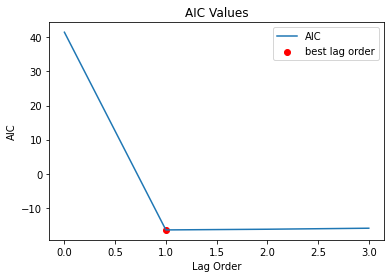

In [6]:
#calculate AIC
x=model.select_order(maxlags=3)
aic=pd.read_html(x.summary().as_html(),header=0, index_col=0)[0][['AIC']]
aic['AIC']=[float(i[0:5]) for i in aic.values.flatten()]
lag_order = aic.idxmin().values[0]

#plot
aic.plot()
plt.scatter(lag_order, aic.loc[lag_order], color='r', label='best lag order')
plt.title('AIC Values')
plt.ylabel('AIC')
plt.xlabel('Lag Order')
plt.legend()
print("Lag order to use is "+str(lag_order))

### Create and fit a model on the data

Using the lag order defined above


In [7]:
model=VAR(df, freq=freq)
model_fit = model.fit(1)

In [8]:
forecast_length = lag_order

#### Iteratively loop through the window size (for n number of windows) and forecast

In [9]:
n_windows = int((len(df) / forecast_length) - 1)
window_size = forecast_length

aa = window_size
dfs=[]
for i in range(0, n_windows):
    start=aa+lag_order
    end=(aa)
    backtest_input = df.values[-start:-end] 
    fc = model_fit.forecast(y=backtest_input, steps=window_size)  
    if i == 0:
        index=df.index[-end:]
    else:
        index=df.index[-end:-(end-window_size)]
    fc = pd.DataFrame(fc, index=index, columns=df.columns)
    dfs.append(fc)
    aa+=window_size                       

#concat results together
fc=pd.concat(dfs)
fc.columns = fc.columns.get_level_values(0)

In [10]:
test=df[df.index.isin(fc.index)]
for i in test.columns:
    print('rmse value for', i, 'is : ', round(rmse(fc[[i]], test[[i]])[0],2))

rmse value for upstream_rainfall is :  48.61
rmse value for predicted_discharge is :  17390.18
rmse value for water_extent is :  173.49
rmse value for okavango_rain is :  44.11


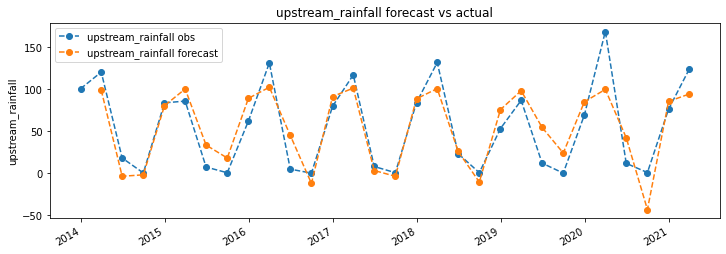

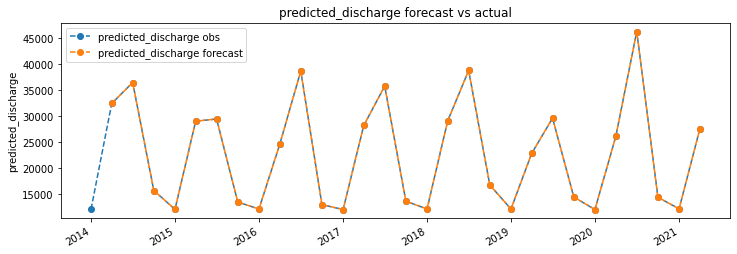

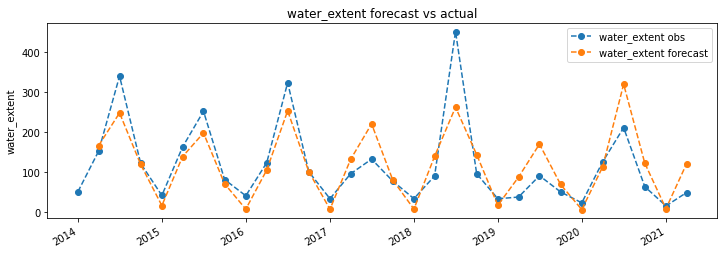

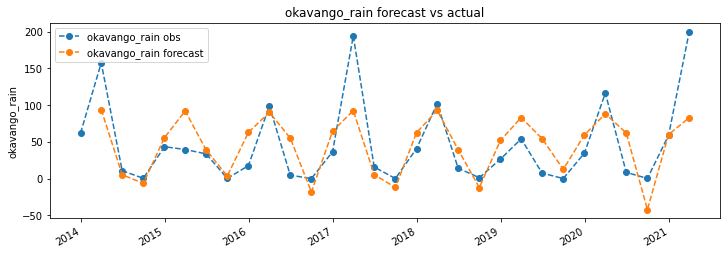

In [11]:
for col in df.columns:
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df[col], label=col+' obs',linestyle='dashed', marker='o')
    fc[col].plot(label=col+' forecast',linestyle='dashed', marker='o')
    plt.ylabel(col)
    plt.title(col+" forecast vs actual")
    plt.legend();


### Forecasting Water Extent

In [12]:
#make final predictions
model = VAR(endog=df, freq=freq)
model_fit = model.fit(lag_order)

pred = model_fit.forecast(df.values[-model_fit.k_ar:], steps=forecast_length)

In [13]:
#converting predictions to dataframe
cols = df.columns
fc = pd.DataFrame(index=range(0,len(pred)), columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(pred)):
        fc.iloc[i][j] = pred[i][j]

fc.index = pd.date_range(freq=freq, start=df.index[-1], periods=len(fc)+1)[1:]
fc.head()


,upstream_rainfall,predicted_discharge,water_extent,okavango_rain
2021-06-30,5.60489,37208,226.002,8.65675


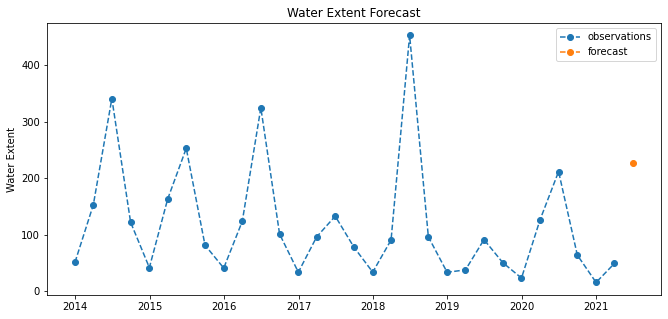

In [14]:
plt.figure(figsize=(11,5))
plt.plot(df.index, df['water_extent'], label='observations',linestyle='dashed', marker='o')
plt.plot(fc.index, fc[['water_extent']], label='forecast',linestyle='dashed', marker='o')
plt.ylabel('Water Extent')
plt.title("Water Extent Forecast")
# plt.ylim(0.0,0.9)
plt.legend();

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).


**Last Tested:**

In [15]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-08-09'